<a href="https://colab.research.google.com/github/sarvesh237/lfkdsahkhfa/blob/master/NewsRecommenderAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt

from scipy.optimize import nnls

#for lemmatization
import nltk
nltk.download("wordnet")
nltk.download('stopwords')
#to remove stop words
from nltk.corpus import stopwords

#for tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

#cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

#gaussian mixture
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import TruncatedSVD# TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Importing the collected data**

In [2]:
df_1 = pd.read_csv("https://github.com/sarvesh237/NewsRecommenderIDC401/raw/master/agrima_news_data.csv")
df_2 = pd.read_csv("https://github.com/sarvesh237/NewsRecommenderIDC401/raw/master/sarvesh_news_data.csv")
df_3 = pd.read_csv("https://github.com/sarvesh237/NewsRecommenderIDC401/raw/master/satender_news_data.csv")
df_4 = pd.read_csv("https://github.com/sarvesh237/NewsRecommenderIDC401/raw/master/vishal_news_data.csv")

# **Preprocessing the csv files.**

In [3]:
del df_1['Unnamed: 0']
del df_2['index']
del df_2['Unnamed: 0']
df_2.rename(columns = {'content':'Content'}, inplace = True)
del df_3['Unnamed: 0']
del df_3['Title']
del df_4['Unnamed: 0']

**Remove capitalization, numbers, stop words, non-english characters, drop empty rows and duplicates.**

In [4]:
news_corpus = pd.concat([df_1,df_2,df_3,df_4],ignore_index=True)
news_corpus = news_corpus.dropna() #dropping NaN
news_corpus = news_corpus[news_corpus.Content != ''] #dropping empty rows
news_corpus = news_corpus.drop_duplicates()
news_corpus["Content"] = news_corpus['Content'].str.replace('[^\w\s]',' ')
news_corpus = news_corpus[news_corpus['Content'].map(lambda x: x.isascii())] #remove non-english #find a better way
news_corpus['Content'] = news_corpus['Content'].str.lower() #convert to lowercase
news_corpus.replace('\d+', '', regex=True, inplace=True) #remove numbers
news_corpus['Content'] = news_corpus['Content'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
stop_words = stopwords.words('english')
stop_words.extend(['span','class','spacing','href','html','http','title','said','that'])
#news_corpus = news_corpus.apply(lambda x: [item for item in x if item not in stop_words])
news_corpus['Content'] = news_corpus['Content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

Storing a second news corpus to show the original news without preprocessing.

In [5]:
news_corpus_org = pd.concat([df_1,df_2,df_3,df_4],ignore_index=True)
news_corpus_org = news_corpus_org.dropna() #dropping NaN
news_corpus_org = news_corpus_org[news_corpus_org.Content != ''] #dropping empty rows
news_corpus_org = news_corpus_org.drop_duplicates()
news_corpus_org["Content"] = news_corpus_org['Content'].str.replace('[^\w\s]',' ')
news_corpus_org = news_corpus_org[news_corpus_org['Content'].map(lambda x: x.isascii())]

#to recover lost punctuations
news_corpus_org_temp = pd.concat([df_1,df_2,df_3,df_4],ignore_index=True)
news_corpus_org_temp = news_corpus_org_temp.dropna() #dropping NaN
news_corpus_org_temp = news_corpus_org_temp[news_corpus_org_temp.Content != ''] #dropping empty rows
news_corpus_org_temp = news_corpus_org_temp.drop_duplicates()

org_news_dict = news_corpus_org_temp.Content.to_dict()
del news_corpus_org['Content']
news_corpus_org['Content'] = news_corpus_org.index
news_corpus_org = news_corpus_org.replace(org_news_dict)
news_corpus_org = news_corpus_org.reset_index(drop=True)

In [6]:
news_corpus_org

,Content
0,Media reports about Swedish bus manufacturer S...
1,"Access to COVID-19 vaccines, cooperation on te..."
2,After severe criticism over not holding consul...
3,Former Congress president Rahul Gandhi on Thur...
4,The Enforcement Directorate has attached three...
...,...
4589,"Over 200 Mughal-era gold coins, dating back to..."
4590,China is planning to spend big in Tibet as it...
4591,The Supreme Court Tuesday came out with a solu...
4592,"Indian-American Maju Varghese, who previously ..."


**Lemmatization**

In [7]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

news_corpus['Content'] = news_corpus.Content.apply(lemmatize_text)
news_corpus['Content'] = news_corpus['Content'].apply(', '.join) #convert list of words to a sentence
news_corpus.replace(',', '', regex=True, inplace=True) # remove commas
news_corpus = news_corpus.reset_index(drop=True)
news_corpus

,Content
0,medium report swedish manufacturer scania gift...
1,access covid vaccine cooperation technology cl...
2,severe criticism holding consultation digital ...
3,former congress president rahul gandhi thursda...
4,enforcement directorate attached three immovab...
...,...
4589,mughal gold coin dating back early century sei...
4590,china planning spend tibet five year plan allo...
4591,supreme court tuesday came solution stalemate ...
4592,indian american maju varghese previously serve...


# TF-IDF

In [8]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(news_corpus.Content)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
#denselist = dense.tolist() #very expensive
df_vecs = pd.DataFrame(dense, columns=feature_names)
df_vecs

,aabad,aadarsh,aadat,aadhaar,aadhar,aadhi,aadmi,aage,aajtak,aakash,aaksha,aamir,aamk,aandolan,aandolanjivi,aane,aapada,aapko,aapsu,aaravv,aarogya,aarohan,aarti,aasha,aashay,aashirwad,aasiya,aastha,aasu,aate,aatma,aatmanidbhar,aatmanirbhar,aatmanirbharbharat,aatmanirbharta,aatmiyata,aatmnirbhar,aatmnirbharta,aawam,aaya,...,zhao,zhoigar,zhuoran,ziarul,zila,zilla,zillion,zimbabwe,zindabad,zindagi,zindagii,zinta,ziyad,zojila,zolgensma,zomato,zombie,zonal,zone,zongqi,zoo,zoological,zoology,zoom,zoonotic,zoramthanga,zothankhuma,zoya,zptcs,ztdrktlic,zuali,zubair,zubin,zurbuchen,zurich,zuxxmlt,zwift,zyada,zycov,zydus
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **LSA : Latent Semantic Analysis**

In [9]:
sv_dec = TruncatedSVD(n_components = 50)  # components(no. of latent factors) < n ; n : no. of docs.
ls_analysis = sv_dec.fit_transform(vectors.T)

sv_dec.singular_values_ # eigenvalues for svd (in decreasing order)

array([11.98935632,  8.18422483,  6.69185019,  6.54219088,  6.16368353,
        5.37562556,  5.16616794,  4.63068752,  4.39650643,  4.32265721,
        4.20088047,  4.16670833,  4.10304161,  4.0659464 ,  3.94312857,
        3.86532609,  3.81088224,  3.76709858,  3.71315746,  3.64150621,
        3.57474246,  3.51150265,  3.43571715,  3.38953093,  3.3370422 ,
        3.30341331,  3.25556473,  3.24576496,  3.1716424 ,  3.13480514,
        3.09625114,  3.04936019,  3.01120729,  2.99590937,  2.97159191,
        2.95149155,  2.89724541,  2.88165471,  2.82421232,  2.81130169,
        2.78870298,  2.78650867,  2.75193503,  2.74649524,  2.71923975,
        2.6940271 ,  2.67719178,  2.65608775,  2.63828113,  2.60885436])

In [10]:
variance =  sv_dec.singular_values_/sum(sv_dec.singular_values_) # checking the variance captured by eigenvalues
variance

array([0.06223132, 0.04248061, 0.03473437, 0.03395755, 0.03199289,
       0.02790244, 0.02681524, 0.0240358 , 0.02282028, 0.02243696,
       0.02180487, 0.0216275 , 0.02129703, 0.02110449, 0.020467  ,
       0.02006316, 0.01978057, 0.0195533 , 0.01927332, 0.01890141,
       0.01855487, 0.01822662, 0.01783325, 0.01759352, 0.01732108,
       0.01714652, 0.01689816, 0.0168473 , 0.01646256, 0.01627136,
       0.01607124, 0.01582785, 0.01562981, 0.01555041, 0.01542419,
       0.01531986, 0.01503829, 0.01495737, 0.01465921, 0.0145922 ,
       0.0144749 , 0.01446351, 0.01428405, 0.01425581, 0.01411434,
       0.01398348, 0.01389609, 0.01378655, 0.01369412, 0.01354138])

In [11]:
sv_dec = TruncatedSVD(n_components = 25) # components with accepted variance
las = sv_dec.fit_transform(vectors)

#print(las,las.shape)

Topic - Document matrix

In [12]:
# Representation of each doc in terms of latent topics after dimensionality reduction
col = []
for i in range(las.shape[1]):
    col.append("topic_{}".format(i)) 

topic_df = pd.DataFrame(las, columns = col)

topic_df["Docs"] = news_corpus.Content

l = ["Docs"]
for i in col:
    l.append(i)

#display(topic_df[l])


**Visualizing the topics**

In [13]:
'''import umap
import matplotlib.pyplot as plt

embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(las)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c = range(4594),s=15 )
plt.show()'''

'import umap\nimport matplotlib.pyplot as plt\n\nembedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(las)\n\nplt.figure(figsize=(7,5))\nplt.scatter(embedding[:, 0], embedding[:, 1], c = range(4594),s=15 )\nplt.show()'

**Topics and terms list**

In [14]:
Sigma = sv_dec.singular_values_ 
V_transpose = sv_dec.components_.T
terms = vectorizer.get_feature_names()

for index, component in enumerate(sv_dec.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)
del Sigma,V_transpose,terms,zipped,top_terms_key

Topic 0:  ['covid', 'case', 'vaccine', 'state', 'farmer', 'minister', 'india', 'government', 'vaccination', 'health']
Topic 1:  ['covid', 'vaccine', 'case', 'death', 'vaccination', 'health', 'total', 'dose', 'reported', 'active']
Topic 2:  ['election', 'assembly', 'party', 'congress', 'vaccine', 'seat', 'poll', 'minister', 'bengal', 'west']
Topic 3:  ['vaccine', 'vaccination', 'farmer', 'dose', 'first', 'covid', 'law', 'modi', 'dos', 'covaxin']
Topic 4:  ['farmer', 'law', 'farm', 'congress', 'party', 'death', 'protest', 'price', 'total', 'hour']
Topic 5:  ['court', 'vaccine', 'supreme', 'justice', 'vaccination', 'petition', 'election', 'bench', 'hearing', 'dose']
Topic 6:  ['police', 'vaccine', 'dose', 'farmer', 'arrested', 'vaccination', 'bengal', 'west', 'accused', 'delhi']
Topic 7:  ['sabha', 'price', 'rajya', 'budget', 'session', 'house', 'congress', 'opposition', 'parliament', 'party']
Topic 8:  ['lakh', 'price', 'sabha', 'bengal', 'fuel', 'west', 'petrol', 'crore', 'data', 'rajya

# **LDA : Latent Dirichlet Allocation**

I have not used this as it was not giving good results.

In [15]:

lda = LatentDirichletAllocation(n_components=25, max_iter=10, learning_method='online', random_state=100)
lda_matrix = lda.fit_transform(df_vecs)
lda_topics = lda.fit(df_vecs)
for idx, topic in enumerate(lda.components_):
        print ("Topic ", idx, " ".join(feature_names[i] for i in topic.argsort()[:-10 - 1:-1]))

Topic  0 nandu taapsee khandwa nand seafarer bahl chabahar phantom suhana maini
Topic  1 amazonia pslv ceraweek nsil patole venkateswara sriharikota khera krishnamurthy cambridge
Topic  2 airwave rjil vodafone upfront quds recontesting recontested infocomm contiguous conservatively
Topic  3 gita geeta bhagavad chidbhavananda edhi chidbhavanandaji shrinate bilquees kindle scholarly
Topic  4 case covid death total reported active health hour dose ministry
Topic  5 dainik overwhelm reining rajgir hisa mahabodhi dhobi lokmat eenadu newsminute
Topic  6 kashmir jammu woman reorganisation restoration farmer abrogation autonomy delimitation people
Topic  7 mullaperiyar jakhar teqip periyar divorced seismoaccelerographs hydrologically widowed thekkady mullaiperiyar
Topic  8 gwarighat mpsja computerised adalat narmada judicial mask worn passenger court
Topic  9 esic nigaar hina gauahar captioned vamika kiss rainbow yummy pehchan
Topic  10 nhrc guruswamy july application amicus court bhardwaj man

In [16]:
col = []
for i in range(lda_matrix.shape[1]):
    col.append("topic_{}".format(i)) 

topic_df_2 = pd.DataFrame(lda_matrix, columns = col)

topic_df_2["Docs"] = news_corpus.Content

l = ["Docs"]
for i in col:
    l.append(i)

topic_df_2

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,Docs
0,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.762872,0.004799,0.126756,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,0.004799,medium report swedish manufacturer scania gift...
1,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.011376,0.919484,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,0.003006,access covid vaccine cooperation technology cl...
2,0.004460,0.004460,0.004460,0.004460,0.004460,0.052048,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.845372,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,0.004460,severe criticism holding consultation digital ...
3,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.895552,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,0.004352,former congress president rahul gandhi thursda...
4,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.051166,0.005201,0.829219,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,0.005201,enforcement directorate attached three immovab...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4589,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.843310,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,0.006529,mughal gold coin dating back early century sei...
4590,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.876539,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,0.005144,china planning spend tibet five year plan allo...
4591,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.922301,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,0.003237,supreme court tuesday came solution stalemate ...
4592,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.862217,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,0.005741,indian american maju varghese previously serve...


Plot LDA topics

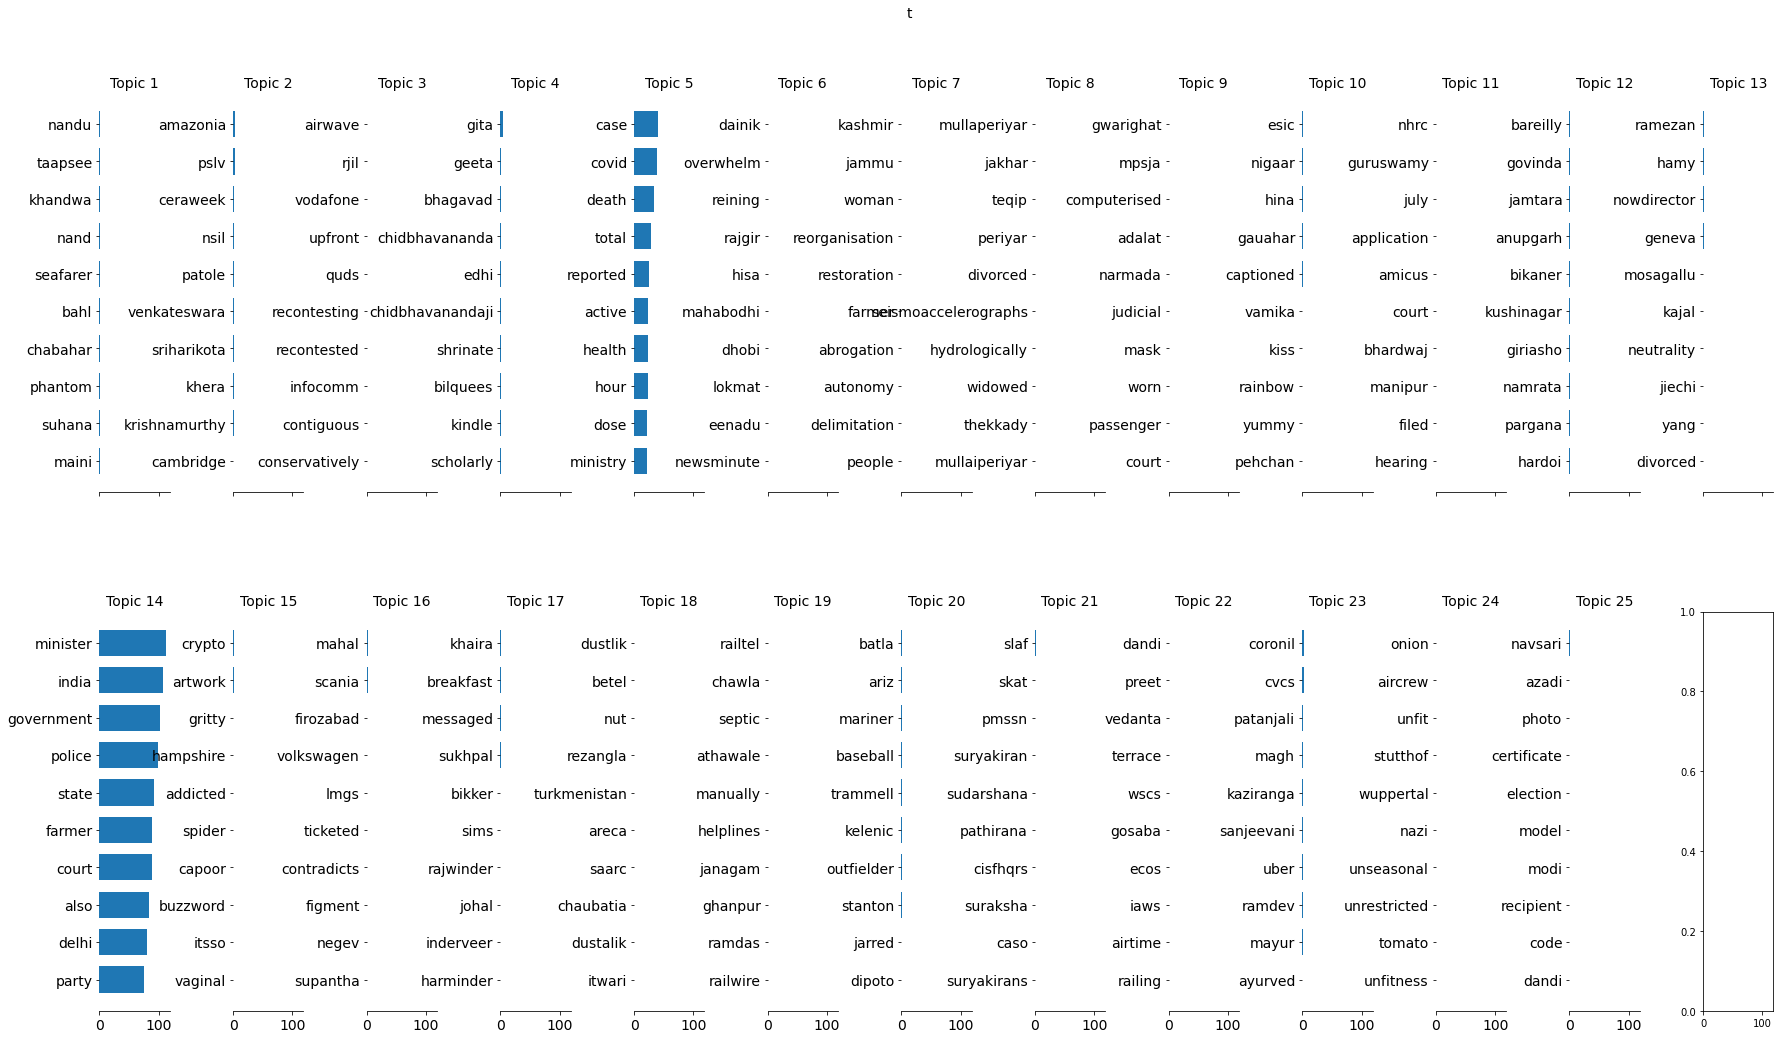

In [17]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 13, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=14)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=14)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda, feature_names, 10, "t")

**Cosine Similarity of documents**

In [18]:
cos_sim = pd.DataFrame(cosine_similarity(topic_df.iloc[:, :-1]))
cos_sim

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4554,4555,4556,4557,4558,4559,4560,4561,4562,4563,4564,4565,4566,4567,4568,4569,4570,4571,4572,4573,4574,4575,4576,4577,4578,4579,4580,4581,4582,4583,4584,4585,4586,4587,4588,4589,4590,4591,4592,4593
0,1.000000,0.441933,0.719989,0.680677,0.664144,0.288173,0.272063,0.335443,0.294520,0.406140,0.579058,0.066253,0.217402,0.104675,0.257925,0.016489,0.536577,0.239752,0.567308,0.304397,0.326446,0.647113,0.602656,0.439884,0.255118,0.325023,0.298562,0.674667,0.673323,0.728992,0.209487,0.089779,0.401944,0.147518,0.404453,0.254256,0.164921,0.372518,0.394642,0.535680,...,0.486253,0.554516,0.427193,0.125504,0.327834,0.660621,0.418274,0.382926,0.376151,0.438325,0.809267,0.472492,0.645372,0.371320,0.569161,0.451522,0.263415,0.537165,0.421533,0.435260,0.463704,0.175286,0.493493,0.458971,0.630713,0.439782,0.339013,0.408764,0.495108,0.449437,0.330227,0.223816,0.600016,0.224549,0.216403,0.468798,0.579262,0.409023,0.324093,0.129812
1,0.441933,1.000000,0.302642,0.668921,0.048745,0.134689,0.258610,0.247309,0.145930,0.537515,0.417404,0.025487,0.020947,0.105938,0.298261,0.155230,0.888929,0.809264,0.285737,-0.011384,0.195930,0.117475,0.152742,0.319238,0.176797,0.204341,0.129176,0.298978,0.175517,0.380977,0.166646,0.284687,0.122961,0.018726,0.466713,0.083799,0.124003,0.509758,0.154890,0.171800,...,0.535979,0.424717,0.426745,-0.018928,0.594185,0.702428,0.446192,0.296224,0.324546,0.716464,0.360869,0.571469,0.676324,0.562493,0.596686,0.208437,0.225324,0.515500,0.422249,0.482766,0.414743,0.060879,0.239608,0.386120,0.478355,0.505784,0.333375,0.595898,0.552248,0.515211,0.503924,0.203157,0.172273,0.155506,0.079442,0.063101,0.635707,0.190268,0.633600,0.118100
2,0.719989,0.302642,1.000000,0.602283,0.193188,0.284391,0.276409,0.314758,0.200714,0.310884,0.445953,0.068894,0.081177,0.192053,0.285189,0.072692,0.482921,0.270064,0.589849,0.135416,0.227688,0.577650,0.295488,0.479666,0.211583,0.256750,0.255783,0.511745,0.511847,0.679418,0.177723,0.190138,0.175513,0.126335,0.237603,0.183721,0.062391,0.146120,0.530560,0.202909,...,0.237100,0.464457,0.343918,-0.015323,0.061271,0.402494,0.352942,0.430915,0.259443,0.311890,0.800053,0.189357,0.670574,0.255309,0.395915,0.297618,0.327812,0.571350,0.150581,0.341101,0.204392,0.087045,0.576483,0.454367,0.278456,0.235411,0.246624,0.195966,0.300305,0.366938,0.263650,0.117059,0.450320,0.237344,0.235167,0.169150,0.293744,0.342398,0.124526,0.086991
3,0.680677,0.668921,0.602283,1.000000,0.291187,0.287079,0.237672,0.385525,0.524015,0.586935,0.611000,0.141753,-0.009722,0.211767,0.258210,0.133904,0.684734,0.462301,0.468947,0.097841,0.560900,0.314676,0.256690,0.534043,0.304129,0.457301,0.144617,0.381452,0.394360,0.443932,0.229209,0.219311,0.252583,0.191634,0.562573,0.224907,0.362835,0.390693,0.232661,0.295656,...,0.525687,0.450966,0.473668,0.057748,0.470851,0.757698,0.479450,0.584407,0.414862,0.500044,0.731920,0.456030,0.722828,0.556935,0.723801,0.392223,0.413987,0.690006,0.407738,0.623099,0.422981,0.251895,0.609025,0.616489,0.559870,0.630814,0.445652,0.555733,0.501676,0.521957,0.505462,0.509363,0.262055,0.385823,0.331346,0.170855,0.505264,0.354317,0.405835,0.014690
4,0.664144,0.048745,0.193188,0.291187,1.000000,0.439951,0.064478,0.324218,0.202015,0.077424,0.329587,0.064874,0.219322,0.128467,0.150916,0.122859,0.164240,-0.034401,0.488476,0.420733,0.202660,0.336369,0.655319,0.197724,0.118315,0.229980,0.145381,0.550927,0.531041,0.343806,0.354695,0.158085,0.592051,0.361393,0.127695,0.517166,0.165484,0.196423,0.156229,0.689548,...,0.283238,0.387478,0.218604,0.029124,0.084546,0.471187,0.206131,0.183475,0.166233,0.217393,0.380220,0.247973,0.146622,0.053330,0.284813,0.465718,0.041231,0.067468,0.250399,0.093391,0.414810,0.076036,0.130869,0.245528,0.519691,0.158089,0.170470,0.137251,0.254285,0.161797,0.155392,0.095359,0.558077,0.092005,0.139629,0.574621,0.368915,0.482030,0.133860,0.174971
...,...,...,...,...,...,...,...,...,...,...,...,..

# **Creating Users and initial ratings**

**Generating Users**

In [19]:
#fitting GMM to column "topic_i"

num_cols_topic_df = topic_df.shape[1]-1
gm = []

for i in range(num_cols_topic_df):
  gm.append(GaussianMixture(n_components=10).fit(topic_df.iloc[:, [i]]))

In [20]:
#generating gmm based topic values for each topic for 50 users
#24 x 50 matrix

Users = []

for i in range(50):
  temp = []
  for i in range(num_cols_topic_df):
    temp.append(gm[i].sample(1)[0][0][0])
  Users.append(temp)
Users=np.array(Users)
Users.T
l2norm = np.sqrt((Users * Users).sum(axis=1))
Users = pd.DataFrame(Users/l2norm.reshape(50,1))

In [21]:
#run the above cell before running this twice
slc = list(range(topic_df.shape[1]))
slc.remove(25)
temp_topic_df = topic_df.iloc[:, slc]
Users_temp = Users.T.set_index(temp_topic_df.T.index)

result = temp_topic_df.dot(Users_temp);
#result.T

**Generating User ratings** 




In [22]:
rank_matrix = result.rank().T/4593*10
rank_matrix = rank_matrix.round(0).astype(int)
rank_matrix.columns =np.linspace(0,4593,4594).astype(int)

#not every reader reads all news
#remove random elements from the rank matrix
for i in range(4594):
  random_entries = np.random.randint(0,50,25)
  rank_matrix.loc[random_entries,i] = "No rating"
rank_matrix = rank_matrix.apply(pd.to_numeric, errors='coerce')
rank_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4554,4555,4556,4557,4558,4559,4560,4561,4562,4563,4564,4565,4566,4567,4568,4569,4570,4571,4572,4573,4574,4575,4576,4577,4578,4579,4580,4581,4582,4583,4584,4585,4586,4587,4588,4589,4590,4591,4592,4593
0,3.0,NaN,2.0,4.0,5.0,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,3.0,5.0,NaN,NaN,7.0,5.0,8.0,NaN,NaN,7.0,NaN,2.0,6.0,1.0,4.0,NaN,10.0,5.0,6.0,NaN,7.0,5.0,NaN,5.0,...,NaN,NaN,3.0,4.0,NaN,2.0,NaN,NaN,1.0,1.0,2.0,2.0,NaN,NaN,1.0,3.0,NaN,2.0,2.0,3.0,2.0,1.0,NaN,NaN,NaN,1.0,3.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,4.0,NaN,2.0,NaN,NaN,NaN
1,NaN,NaN,9.0,8.0,2.0,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN,5.0,7.0,NaN,8.0,NaN,6.0,NaN,9.0,NaN,6.0,4.0,10.0,NaN,5.0,NaN,4.0,6.0,NaN,8.0,2.0,NaN,NaN,3.0,2.0,NaN,NaN,NaN,...,2.0,6.0,4.0,NaN,NaN,NaN,NaN,1.0,3.0,2.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,2.0,4.0,1.0,NaN,NaN,NaN,NaN,3.0,1.0,NaN,2.0,2.0,1.0,2.0,NaN,NaN,9.0,NaN,6.0,NaN,6.0,7.0
2,NaN,NaN,NaN,NaN,4.0,6.0,1.0,3.0,3.0,8.0,NaN,NaN,4.0,4.0,1.0,7.0,6.0,NaN,2.0,4.0,9.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,8.0,NaN,7.0,NaN,7.0,6.0,8.0,6.0,NaN,4.0,...,NaN,NaN,1.0,NaN,NaN,2.0,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN,3.0,2.0,1.0,2.0,NaN,1.0,2.0,NaN,2.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,3.0,NaN,NaN,NaN
3,NaN,4.0,NaN,NaN,NaN,2.0,8.0,NaN,8.0,NaN,3.0,10.0,4.0,1.0,5.0,2.0,NaN,NaN,5.0,9.0,NaN,4.0,7.0,NaN,9.0,9.0,6.0,2.0,8.0,5.0,NaN,NaN,7.0,4.0,NaN,NaN,NaN,3.0,NaN,5.0,...,NaN,2.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,1.0,NaN,NaN,2.0,3.0,NaN,8.0,NaN,3.0,3.0,NaN,5.0
4,NaN,8.0,NaN,NaN,6.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,3.0,3.0,NaN,8.0,6.0,6.0,NaN,4.0,NaN,6.0,8.0,NaN,NaN,7.0,5.0,2.0,7.0,NaN,NaN,NaN,8.0,NaN,7.0,8.0,10.0,NaN,6.0,7.0,...,NaN,4.0,2.0,0.0,NaN,NaN,1.0,1.0,2.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,2.0,NaN,NaN,2.0,4.0,NaN,1.0,1.0,2.0,NaN,1.0,1.0,2.0,NaN,3.0,NaN,1.0,NaN,2.0,3.0,5.0,1.0,NaN
5,NaN,NaN,7.0,8.0,NaN,7.0,9.0,NaN,NaN,6.0,3.0,NaN,2.0,NaN,2.0,5.0,5.0,7.0,4.0,NaN,NaN,3.0,8.0,4.0,8.0,6.0,2.0,NaN,NaN,2.0,8.0,2.0,8.0,4.0,6.0,7.0,4.0,3.0,NaN,2.0,...,0.0,3.0,1.0,NaN,NaN,1.0,0.0,NaN,0.0,0.0,2.0,NaN,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,NaN,0.0,1.0,0.0,NaN,NaN,0.0,NaN,1.0,0.0,0.0,1.0,2.0,NaN,1.0,2.0,5.0,2.0,5.0
6,6.0,8.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,8.0,NaN,3.0,8.0,NaN,NaN,0.0,5.0,4.0,3.0,9.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,1.0,5.0,1.0,6.0,1.0,1.0,NaN,4.0,3.0,...,NaN,5.0,NaN,5.0,5.0,3.0,2.0,2.0,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,5.0,4.0,2.0,3.0,NaN,3.0,NaN,3.0,4.0,NaN,3.0,3.0,4.0,2.0,2.0,5.0,NaN,NaN,3.0,NaN,5.0,3.0,1.0
7,7.0,NaN,9.0,3.0,NaN,NaN,8.0,4.0,NaN,NaN,4.0,NaN,8.0,NaN,5.0,8.0,NaN,1.0,6.0,10.0,NaN,9.0,NaN,NaN,9.0,NaN,7.0,4.0,NaN,6.0,NaN,7.0,5.0,NaN,NaN,9.0,NaN,NaN,7.0,1.0,...,NaN,7.0,NaN,4.0,2.0,NaN,NaN,2.0,3.0,2.0,4.0,3.0,NaN,2.0,NaN,2.0,NaN,NaN,4.0,3.0,3.0,1.0,2.0,NaN,NaN,NaN,2.0,3.0,4.0,NaN,NaN,NaN,7.0,NaN,NaN,4.0,4.0,10.0,3.0,NaN
8,4.0,3.0,7.0,3.0,7.0,NaN,7.0,7.0,9.0,NaN,3.0,NaN,NaN,5.0,NaN,7.0,6.0,NaN,7.0,5.0,7.0,NaN,8.0,6.0,9.0,7.0,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,1.0,9.0,2.0,NaN,5.0,NaN,...,NaN,NaN,NaN,2.0,3.0,2.0,2.0,2.0,NaN,4.0,3.0,NaN,NaN,NaN,2.0,NaN,NaN,2.0,3.0,NaN,4.0,1.0,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,3.0,4.0,4.0,NaN,4.0,4.0,NaN,NaN,7.0,8.0
9,6.0,5.0,5.0,9.0,NaN,NaN,8.0,4.0,9.0,5.0,5.0,10.0,2.0,NaN,5.0,NaN,NaN,1.0,NaN,1.0,9.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,8.0,NaN,NaN,8.0,8.0,NaN,NaN,7.0,...,2.0,3.0,4.0,NaN,5.0,5.0,2.0,3.0,4.0,NaN,NaN,3.0,NaN,3.0,3.0,5.0,NaN,4.0,NaN,6.0,5.0,NaN,3.0,NaN,2.0,5.0,2.0,3.0,2.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,NaN


# **Content based recommender function**

In [23]:
def content_recommender(rank_matrix,cos_sim):
  
  #find top 5 ratings
  top_five = rank_matrix.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=5)

  #best two similar docs for every doc
  best_two = cos_sim.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=3)
  best_two.columns =['0', '1','2']
  del best_two['0']
  best_two['combined']= best_two.values.tolist()
  best_two
  best_two_dict_1 = best_two['1'].to_dict()
  best_two_dict_2 = best_two['2'].to_dict()

  selected_docs_1 = top_five.replace(best_two_dict_1)
  selected_docs_2 = top_five.replace(best_two_dict_2)
  selected_docs_with_ID = pd.concat([selected_docs_1,selected_docs_2],axis=1,ignore_index=True)

  #replace value by the actual news
  doc_dict = news_corpus_org.Content.to_dict()

  selected_docs = selected_docs_with_ID.replace(doc_dict)
  return selected_docs, selected_docs_with_ID

# **Top 10 news : Content based recommender.**

In [24]:
selected_docs_content,selected_docs_content_with_ID = content_recommender(rank_matrix,cos_sim)
selected_docs_content

,0,1,2,3,4,5,6,7,8,9
0,"With this, the total number of arrests made i...",Congress leader Rahul Gandhi on Sunday compar...,"New Delhi [India], March 1 (ANI): The cumulat...","Birbhum (West Bengal) [India], February 23 (A...","New Delhi [India], February 25 (ANI): With 3,...",Delhi Police has made two more arrests in the...,Urging the Centre not to make the agri laws a ...,Nearly 17 lakh COVID vaccine doses were admini...,Kolkata (West Bengal) [India] March 11 (ANI):...,"New Delhi [India], February 26 (ANI): With 2,..."
1,The Parliament will have an extended four-day...,The British Parliament will discuss the three ...,The British parliament on Monday discussed fa...,Women are likely to play a major role in ensur...,"New Delhi [India], March 8 (ANI): Rajya Sabha...",Rajya Sabha Chairman Venkaiah Naidu on Tuesday...,The British parliament on Monday discussed fa...,The Indian High Commission in London has cond...,NEW DELHI (Reuters) - Thousands of women join...,"The low participation of non-Congress, non-BJP..."
2,"Lauding India for its vaccine leadership, a t...",The British parliament on Monday discussed fa...,Congress leader Rahul Gandhi on Sunday compar...,The daily new coronavirus (COVID-19) cases fe...,New cases of coronavirus infection in India w...,International Monetary Fund (IMF) chief econo...,The Indian High Commission in London has cond...,Urging the Centre not to make the agri laws a ...,Daily COVID-19 cases in India registered an i...,The daily new coronavirus (COVID-19) cases fe...
3,Daily COVID-19 cases in India registered an i...,Tirath Singh Rawat has been sworn in as the ne...,"New Delhi [India], March 8 (ANI): Rajya Sabha...","﻿Eighteen States/UTs, including Assam, Rajasth...","Maharashtra, Kerala, Punjab, Tamil Nadu, Gujar...",New cases of coronavirus infection in India w...,"Dehradun (Uttarakhand) [India], March 9 (ANI)...","The low participation of non-Congress, non-BJP...",With several States in the country continuing ...,"Maharashtra, Kerala, Punjab, Tamil Nadu and G..."
4,"Udhampur (Jammu and Kashmir) [India], March 8...","Amaravati (Andhra Pradesh) [India], March 8 (...",Tirath Singh Rawat has been sworn in as the ne...,"By Aiman KhanNew Delhi [India], March 6 (ANI)...","Kochi (Kerala) [India], March 4 (ANI): Kerala...",Prime Minister Narendra Modi on Tuesday gave a...,"New Delhi [India], March 5 (ANI): The Nationa...","Dehradun (Uttarakhand) [India], March 9 (ANI)...","By Siddharth SharmaNew Delhi [India], Februar...","Jodhpur (Rajasthan) [India], March 6 (ANI): T..."
5,"The first ‘Quadrilateral Security Dialogue’, ...","Amaravati (Andhra Pradesh) [India], March 8 (...","Maharashtra, Kerala, Punjab, Tamil Nadu, Gujar...","Kochi (Kerala) [India], March 4 (ANI): Kerala...","﻿Eighteen States/UTs, including Assam, Rajasth...",Calling External Affairs Minister S. Jaishanka...,"New Delhi [India], March 5 (ANI): The Nationa...","Maharashtra, Kerala, Punjab, Tamil Nadu and G...","Jodhpur (Rajasthan) [India], March 6 (ANI): T...",With several States in the country continuing ...
6,The government will provide ₹ 1 lakh crore ad...,"Pune (Maharashtra) [India], March 5 (ANI): Un...","New Delhi [India], March 2 (ANI): Private hos...","Lucknow (Uttar Pradesh) [India], March 6 (ANI...",Farmer leaders heading the agitation against t...,"Chandigarh (Punjab) [India], March 5 (ANI): P...","New Delhi [India], March 8 (ANI): The cumulat...","New Delhi [India], March 9 (ANI): To review t...",As the COVID-19 vaccination campaign continue...,"Shivamogga (Karnataka) [India], February 25 (..."
7,Vocational courses will be introduced phase-w...,The Congress on Monday demanded a rollback of ...,The cumulative doses of COVID19 vaccine admini...,"New Delhi [India], February 26 (ANI): The Cen...",The Supreme Court on Monday asked the Centre t...,"New Delhi [India], March 8 (ANI): The advance...",Cornering the government on spiralling fuel pr...,Nearly 17 lakh COVID vaccine doses were admini...,"The story so far: On Thursday, in a lo

# **Collaborative recommender function: Predict missing ratings using Matrix factorization**

In [25]:
#collaborative recommender function

def collaborative_recommender(rank_matrix,num_iter,news_corpus):
  A = np.array(rank_matrix)
  M = A.shape[0]
  N = A.shape[1]
  A_df = pd.DataFrame(A)
  K = 25
  W = np.abs(np.random.uniform(low=0, high=1, size=(M, K)))
  H = np.abs(np.random.uniform(low=0, high=1, size=(K, N)))
  W = np.divide(W, K*W.max())
  H = np.divide(H, K*H.max())

  #cost func
  def cost(A, W, H):
    mask = pd.DataFrame(A).notnull().values
    WH = np.dot(W, H)
    WH_mask = WH[mask]
    A_mask = A[mask]
    A_WH_mask = A_mask-WH_mask
    return linalg.norm(A_WH_mask, 2)
  
  #optimization loop
  num_display_cost = max(int(num_iter/10), 1)

  for i in range(num_iter):
      if i%2 ==0:
          # Learn H, given A and W
          for j in range(N):
              mask_rows = pd.Series(A[:,j]).notnull()
              H[:,j] = nnls(W[mask_rows], A[:,j][mask_rows])[0]
      else:
          for j in range(M):
              mask_rows = pd.Series(A[j,:]).notnull()
              W[j,:] = nnls(H.transpose()[mask_rows], A[j,:][mask_rows])[0]
              
      WH = np.dot(W, H)
      c = cost(A, W, H)
      #if i%num_display_cost==0:
      print(i, c)
  W = pd.DataFrame(W)
  H = pd.DataFrame(H)
  A = W.dot(H)
  
  #new rank matrix
  A = A.round(0).astype(int)
  A = np.clip(A,1,10)
  #finding the top 10 documents
  selected_docs_with_ID = A.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=10)
  selected_docs_with_ID.columns =['1', '2', '3', '4', '5','6','7','8','9','10']
  doc_dict = news_corpus_org.Content.to_dict()
  selected_docs = selected_docs_with_ID.replace(doc_dict)
  return selected_docs, selected_docs_with_ID

# **Top 10 news : Collaborative recommender.**

In [26]:
num_iter = 10
selected_docs_collab,selected_docs_collab_with_ID = collaborative_recommender(rank_matrix,num_iter,news_corpus)
selected_docs_collab

0 786.9161824195887
1 653.5061422878699
2 548.9350983607795
3 479.7849788880074
4 434.4116048577371
5 406.6617742567877
6 387.15803984695583
7 371.97788143687575
8 359.9031072738692
9 350.10181468022046


,1,2,3,4,5,6,7,8,9,10
0,New Delhi Prime Minister Narendra Modi on Tue...,"Kolkata Six BJP activists were injured, two of...",The National Human Rights Commission (NHRC) h...,The National Investigation Agency (NIA) took o...,Faced with farm union leader Rakesh Tikait’s t...,Agitating farmer union on February 23 objected...,Two persons claiming to be the personnel of De...,Delhi Police have arrested a protester for all...,The ruling Congress swept the municipal polls ...,The focus of investigation by the Delhi Police...
1,India will continue dialogue with China till d...,"For the third day in a row, both Houses of Par...",Discussion on the farm laws by the British Par...,"The low participation of non-Congress, non-BJP...",The High Commission of India in London has con...,Multi-billion deals for 30 armed drones from t...,Rajya Sabha Chairman M. Venkaiah Naidu on Mar...,Congress General Secretary Priyanka Gandhi Vad...,Continuing with his attack on the BJP governm...,Agriculture Minister Narendra Singh Tomar on S...
2,"Access to COVID-19 vaccines, cooperation on te...",The first ever summit of the leaders of the Qu...,"Lauding India for its vaccine leadership, a t...",The High Commission of India in London has con...,Prime Minister Narendra Modi on Monday said th...,Conveying his strong appreciation for the “res...,Maintaining that the new agricultural laws are...,India and Sweden can deepen their partnership...,The Delhi High Court March 4 asked the Centre...,Criminal activities are responsible for the ki...
3,India recorded its highest daily tally of COV...,The Election Commission (EC) on Tuesday issued...,"The low participation of non-Congress, non-BJP...",The crisis over the continuation of Uttarakhan...,New cases of coronavirus infection in India w...,"India’s COVID-19 tally rose to 1,11,92,088 wi...",No new COVID-19 fatalities have been reported ...,A week after the show of strength in Jammu by ...,"Maharashtra, Kerala, Punjab, Tamil Nadu, Gujar...",India’s total tally of COVID-19 cases rose to...
4,The Union home ministry on Monday said ₹ 200 ...,The crisis over the continuation of Uttarakhan...,"BJP leader Jyotiraditya Scindia, who quit the ...",Congress General Secretary Priyanka Gandhi Vad...,Conveying his strong appreciation for the “res...,"Maharashtra, Kerala, Punjab, Tamil Nadu, Gujar...",Former Congress president Rahul Gandhi on Tues...,The Health Ministry urged States/UTs to utilis...,With several States in the country continuing ...,Remarking that a normal bilateral trade relati...
5,"Access to COVID-19 vaccines, cooperation on te...",The first ever summit of the leaders of the Qu...,Prime Minister Narendra Modi and his Japanese...,Prime Minister Narendra Modi on Tuesday virtua...,The High Commission of India in London has con...,The Union home ministry on Monday said ₹ 200 ...,Conveying his strong appreciation for the “res...,The Congress is changing the way it selects ca...,The Andhra Pradesh government orally stated in...,External Affairs Minister Jaishankar will visi...
6,The first ever summit of the leaders of the Qu...,Principal Secretary to Prime Minister P.K. Mis...,Congress General Secretary Priyanka Gandhi Vad...,Prime Minister Narendra Modi on March 7 said t...,Prime Minister Narendra Modi on Friday said p...,Criminal activities are responsible for the ki...,The cumulative number of COVID-19 vaccine dose...,The Health Ministry urged States/UTs to utilis...,Prime Minister Narendra Modi early on Monday t...,Describing the contentious farm laws as “death...
7,"For the third day in a row, both Houses of Par...",A Constitution Bench led by Chief Justice of I...,Noting that the budgetary allocation for agric...,The Supreme Court on Tuesday asked the governm...,"Price of domestic cooking gas, LPG has double...",The government has said the amendments introdu...,Multiple adjournment motions marred the workin...,A parliamentary committee has recommended that...,Leader of the Opposition in the Rajya Sabha Ma...,Pr

# **Hydrid recommender**

In [27]:
def hybrid(collaborative_recommender,content_recommender,rank_matrix,cos_sim,news_corpus):
  selected_docs_collab,selected_docs_collab_with_ID = collaborative_recommender(rank_matrix,num_iter,news_corpus)
  selected_docs_content,selected_docs_content_with_ID = content_recommender(rank_matrix,cos_sim)
  
  selected_docs_collab.reset_index(drop=True, inplace=True)
  selected_docs_content.reset_index(drop=True, inplace=True)
  
  selected_docs_collab_with_ID.reset_index(drop=True, inplace=True)
  selected_docs_content_with_ID.reset_index(drop=True, inplace=True)
  
  selected_docs_final = pd.concat([selected_docs_content.iloc[:,[0,1,2,3,4]],selected_docs_collab.iloc[:,[5,6,7,8,9]]],axis=1)
  selected_docs_final_with_ID = pd.concat([selected_docs_content_with_ID.iloc[:,[0,1,2,3,4]],selected_docs_collab_with_ID.iloc[:,[5,6,7,8,9]]],axis=1)
  
  return selected_docs_final,selected_docs_final_with_ID

# **Top 10 news : Hybrid recommender.**

In [28]:
selected_docs_final,selected_docs_final_with_ID = hybrid(collaborative_recommender,content_recommender,rank_matrix,cos_sim,news_corpus)
selected_docs_final

0 780.0003117098314
1 637.7177948836991
2 530.2466467899905
3 462.064468661806
4 416.97053290744725
5 389.00911173069466
6 369.52400398946196
7 355.0667658098065
8 344.3053348167997
9 336.0915883669576


,0,1,2,3,4,6,7,8,9,10
0,"With this, the total number of arrests made i...",Congress leader Rahul Gandhi on Sunday compar...,"New Delhi [India], March 1 (ANI): The cumulat...","Birbhum (West Bengal) [India], February 23 (A...","New Delhi [India], February 25 (ANI): With 3,...",Health Minister Harsh Vardhan on Wednesday rei...,President Ram Nath Kovind on Tuesday was admin...,The National Investigation Agency (NIA) took o...,An organisation named Jaish-ul-Hind has claime...,The cumulative number of COVID-19 vaccine dose...
1,The Parliament will have an extended four-day...,The British Parliament will discuss the three ...,The British parliament on Monday discussed fa...,Women are likely to play a major role in ensur...,"New Delhi [India], March 8 (ANI): Rajya Sabha...",The inclusion of India in the United States’s...,The High Commission of India in London has con...,Rajya Sabha Chairman M. Venkaiah Naidu on Mar...,Congress General Secretary Priyanka Gandhi Vad...,Conveying his strong appreciation for the “res...
2,"Lauding India for its vaccine leadership, a t...",The British parliament on Monday discussed fa...,Congress leader Rahul Gandhi on Sunday compar...,The daily new coronavirus (COVID-19) cases fe...,New cases of coronavirus infection in India w...,Prime Minister Narendra Modi on Monday said th...,Congress General Secretary Priyanka Gandhi Vad...,Prime Minister Narendra Modi on March 7 said t...,Agriculture Minister Narendra Singh Tomar on S...,Maintaining that the new agricultural laws are...
3,Daily COVID-19 cases in India registered an i...,Tirath Singh Rawat has been sworn in as the ne...,"New Delhi [India], March 8 (ANI): Rajya Sabha...","﻿Eighteen States/UTs, including Assam, Rajasth...","Maharashtra, Kerala, Punjab, Tamil Nadu, Gujar...",A week after the show of strength in Jammu by ...,"Maharashtra, Kerala, Punjab, Tamil Nadu, Gujar...","Maharashtra, Kerala, Punjab, Tamil Nadu, Gujar...","Maharashtra, Kerala, Punjab, Tamil Nadu, Gujar...","Maharashtra, Kerala, Punjab, Tamil Nadu and G..."
4,"Udhampur (Jammu and Kashmir) [India], March 8...","Amaravati (Andhra Pradesh) [India], March 8 (...",Tirath Singh Rawat has been sworn in as the ne...,"By Aiman KhanNew Delhi [India], March 6 (ANI)...","Kochi (Kerala) [India], March 4 (ANI): Kerala...",As the farmers protest completed 100 days on t...,Former Congress president Rahul Gandhi on Tues...,Distancing himself from the Jammu meet of G-2...,A day after the group of dissenting Congress l...,"The COVID-19 active caseload has reached 1,59,..."
5,"The first ‘Quadrilateral Security Dialogue’, ...","Amaravati (Andhra Pradesh) [India], March 8 (...","Maharashtra, Kerala, Punjab, Tamil Nadu, Gujar...","Kochi (Kerala) [India], March 4 (ANI): Kerala...","﻿Eighteen States/UTs, including Assam, Rajasth...",No new COVID-19 fatalities have been reported ...,A week after the show of strength in Jammu by ...,External Affairs Minister Jaishankar will visi...,"Maharashtra, Kerala, Punjab, Tamil Nadu, Gujar...",U.S.-based human rights watchdog Freedom House...
6,The government will provide ₹ 1 lakh crore ad...,"Pune (Maharashtra) [India], March 5 (ANI): Un...","New Delhi [India], March 2 (ANI): Private hos...","Lucknow (Uttar Pradesh) [India], March 6 (ANI...",Farmer leaders heading the agitation against t...,Prime Minister Narendra Modi on March 7 said t...,Agriculture Minister Narendra Singh Tomar on S...,Prime Minister Narendra Modi on Friday said p...,Health Minister Harsh Vardhan on Wednesday rei...,President Ram Nath Kovind on Tuesday was admin...
7,Vocational courses will be introduced phase-w...,The Congress on Monday demanded a rollback of ...,The cumulative doses of COVID19 vaccine admini...,"New Delhi [India], February 26 (ANI): The Cen...",The Supreme Court on Monday asked the Centre t...,Former Congress president Rahul Gandhi on Tues...,There are 888 road projects delayed under the ...,Noting that the budgetary allocation for agric...,The Supreme Court on Tuesday asked the 

In [29]:
selected_docs_final_with_ID

,0,1,2,3,4,6,7,8,9,10
0,1711,1550,3198,3999,3679,181,190,200,244,285
1,1772,175,1722,1213,2450,68,71,98,104,123
2,1855,1722,1550,602,117,93,104,118,126,148
3,404,4492,2450,534,192,150,174,183,192,217
4,2479,2404,4492,2661,2877,147,204,229,246,273
5,1838,2404,174,2877,534,146,150,176,183,187
6,791,2794,3094,2716,879,118,126,159,181,190
7,963,532,141,3563,1534,43,45,58,65,67
8,952,2157,602,117,2157,181,190,199,205,222
9,404,1739,204,602,174,138,146,150,174,183


# **User Profile Updater**

Implemented in the flask app.

# **Implement ALS based matrix factorization instead of NNLS**

I'll delete this before submitting.

In [30]:
'''from pyspark.ml.recommendation import ALS 
from pyspark.sql.types import FloatType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

X_train, X_test = rank_matrix.randomSplit([0.6, 0.4])'''

'from pyspark.ml.recommendation import ALS \nfrom pyspark.sql.types import FloatType\nfrom pyspark.ml.evaluation import RegressionEvaluator\nfrom pyspark.sql.functions import col\n\nX_train, X_test = rank_matrix.randomSplit([0.6, 0.4])'

In [31]:
'''als = mlALS(rank=5, maxIter=10, seed=0)
model = als.fit(rank_matrix)'''

'als = mlALS(rank=5, maxIter=10, seed=0)\nmodel = als.fit(rank_matrix)'